Importing dependancies

In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [20]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

Load CSV

In [21]:
df = pd.read_excel('/content/hardware_pow_data.xlsx')

In [22]:
df.to_csv('/content/hardware_pow_data.csv')

converting timestamp to datetime

In [23]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

selecting a node to model/selecting all nodes

In [24]:
power_columns = []  # Create an empty list to store column names

for col in df.columns:
    if '-Pow-consumption' in col:
        power_columns.append(col)

# Calc total pow consumption by adding all value in list
df['Total_Power'] = df[power_columns].sum(axis=1)



Preprocessing

In [25]:
scaler = MinMaxScaler()
print(df.isnull().values.any())
df.fillna(df.mean(), inplace=True)
power_scaled = scaler.fit_transform(df["Total_Power"].values.reshape(-1, 1))

True


In [26]:
#creating sequence for LSTM #breaking the power series into chunks

In [27]:
def create_sequences(data,time_steps=10):
  X,y=[],[]
  for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
  return np.array(X), np.array(y)

In [28]:
time_steps = 10
X, y = create_sequences(power_scaled, time_steps=10)

Train/Test/validate Split

In [35]:
total_length =len(X)
train_size=(0.6* total_length)
test_size = (0.2 * total_length)
val_size = total_length - train_size - test_size

X_train = X[:int(train_size)]
y_train = y[:int(train_size)]

X_test = X[int(train_size):int(train_size)+int(test_size)]
y_test = y[int(train_size):int(train_size)+int(test_size)]

x_val = X[int(train_size)+int(test_size):]
y_val = y[int(train_size)+int(test_size):]

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")
print(f"Validation: {x_val.shape}, {y_val.shape}")

Train: (23781, 10, 1), (23781, 1)
Test: (7927, 10, 1), (7927, 1)
Validation: (7928, 10, 1), (7928, 1)


Build and Train Data

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
#train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


744/744 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0398
Epoch 2/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 8.6395e-04
Epoch 3/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 7.2551e-04
Epoch 4/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 6.4154e-04
Epoch 5/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 5.5782e-04
Epoch 6/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 4.4653e-04
Epoch 7/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4.2932e-04
Epoch 8/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3.5519e-04
Epoch 9/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3.1031e-04
Epoch 10/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.8907e-04


In [37]:
y_pred_test = model.predict(X_test)
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


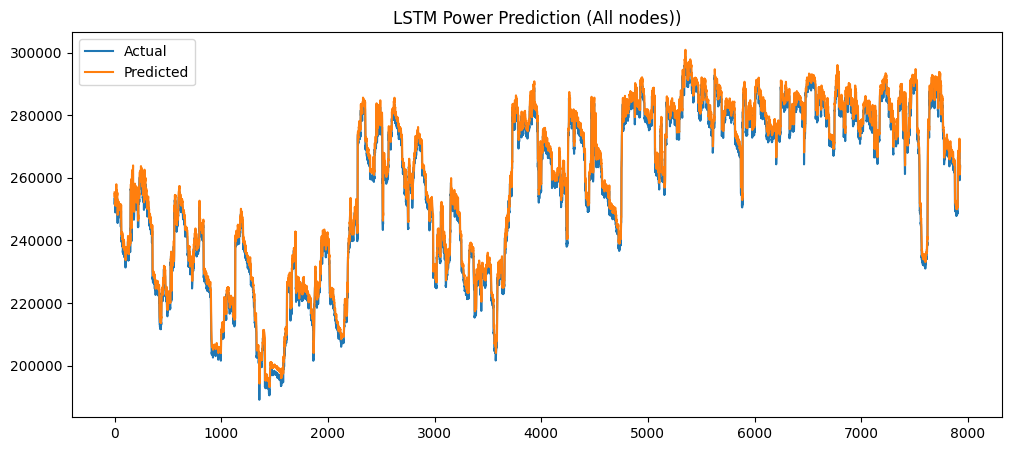

248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


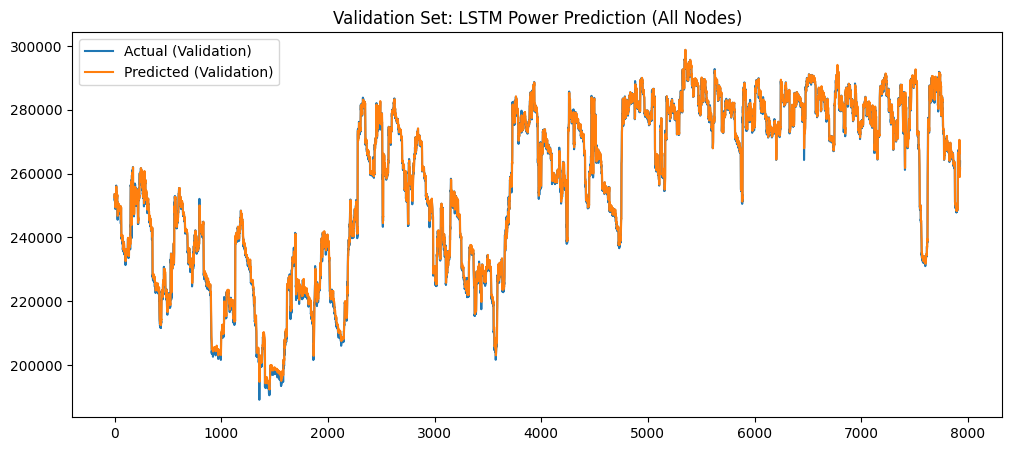

Test Set Metrics:
MAE  = 1643.18
MSE  = 6652603.74
RMSE = 2579.26
R² Score = 0.9912

Validation Set Metrics:
MAE  = 1224.68
MSE  = 4225755.23
RMSE = 2055.66
R² Score = 0.9938


In [44]:
plt.figure(figsize=(12,5))
plt.plot(actual_inv, label='Actual')
plt.plot(predicted_inv, label='Predicted')
plt.title("LSTM Power Prediction (All nodes))")
plt.legend()
plt.show()

#Predict on VALIDATION SET and Plot (NEW BLOCK)
y_pred_val = model.predict(x_val)
y_pred_val_inv = scaler.inverse_transform(y_pred_val)
y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

plt.figure(figsize=(12,5))
plt.plot(y_val_inv, label='Actual (Validation)')
plt.plot(y_pred_val_inv, label='Predicted (Validation)')
plt.title("Validation Set: LSTM Power Prediction (All Nodes)")
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

#Evaluate on TEST set
mse_test = mean_squared_error(y_test_inv, y_pred_test_inv)
mae_test = mean_absolute_error(y_test_inv, y_pred_test_inv)
rmse_test = math.sqrt(mse_test)
r2_test = r2_score(y_test_inv, y_pred_test_inv)

print("Test Set Metrics:")
print(f"MAE  = {mae_test:.2f}")
print(f"MSE  = {mse_test:.2f}")
print(f"RMSE = {rmse_test:.2f}")
print(f"R² Score = {r2_test:.4f}")

#Evaluate on VALIDATION set
mse_val = mean_squared_error(y_val_inv, y_pred_val_inv)
mae_val = mean_absolute_error(y_val_inv, y_pred_val_inv)
rmse_val = math.sqrt(mse_val)
r2_val = r2_score(y_val_inv, y_pred_val_inv)

print("\nValidation Set Metrics:")
print(f"MAE  = {mae_val:.2f}")
print(f"MSE  = {mse_val:.2f}")
print(f"RMSE = {rmse_val:.2f}")
print(f"R² Score = {r2_val:.4f}")
